# Visualization/Analysis of Local GTFS-RT

In [41]:
import json
import os

from datetime import datetime, timezone

import branca.colormap as cm
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns

TZ = pytz.timezone('America/Los_Angeles')

In [42]:
corridor_segments = {
    0: {
        2749,
        2751,
        2752,
        2753,
        2754,
        2755,
        2756,
        2757
    },
    1: {
        12200,
        12201,
        12202,
        12203,
        12204
    },
    2: {
        13532,
        13533,
        13534,
        13535,
        13536
    },
    3: {
        14585,
        14586,
        14587,
        14589,
        14590,
        14591,
        14243
    },
    4: {
        8510,
        8511,
        8512,
        8513,
        8514
    },
    5: {
        13221,
        13220,
        13219,
        13218,
        13217
    },
    6: {
        18045,
        18046,
        18047,
        18048,
        18049
    },
    7: {
        19235,
        19234,
        11333,
        11331,
        11330,
        11329,
        19212
    },
    8: {
        12369,
        12366,
        12365,
        12364,
        12363
    }
}

### Process the Local Summarize_RDS Data

In [43]:
# Location for the local data
path = './transit_vis/data/to_upload'
files = os.listdir(path)

# Join all the data which is saved in different csv for each day
# frames = [pd.read_csv(f"{path}/{filename}", dtype={'trip_short_name': str, 'route_short_name': str}) for filename in files[0:30]]
# all_data = pd.concat(frames)
# all_data.to_csv(f"{path}/../all_data.csv")
# all_data.head()

# If already processed, load the data here and comment out above
all_data = pd.read_csv(f"{path}/../all_data.csv", dtype={'trip_short_name': str, 'route_short_name': str})
all_data.head()

# Rename and style
all_data['speed_m_s'] = all_data['avg_speed_m_s']
#all_data = all_data[all_data['at_stop'] == True]

sns.set_style('whitegrid')

### Find Top 10/Top Random Coaches that Spend Most Time in Corridors, and Avg Unique Corridor Traversals

In [44]:
# Filter to period of interest
# start_time = 1607072400 # 12/4/20 1AM
# end_time = 1608282000 # 12/18/20 1AM
start_time = 1607518800 # 12/9/20 5AM
end_time = 1607583600 # 12/9/20 11PM
all_data = all_data.loc[(all_data['locationtime'] > start_time) & (all_data['locationtime'] < end_time)]

# Get list of all segments in our corridors
segments_dict = list(corridor_segments.values())
all_corridor_segments = []
for item in segments_dict:
    for seg in item:
        all_corridor_segments.append(seg)

# Filter to only tracked locations in our corridors
data = all_data.loc[all_data['seg_compkey'].isin(all_corridor_segments)]
del all_data

#data.to_csv("for_borna.csv")

(array([121., 152., 132., 188., 167., 184., 197., 196., 246., 225., 214.,
        190., 198., 187., 199., 181., 110., 133., 153., 130., 142., 150.,
        139., 121., 171., 196., 140., 122., 165., 191., 175., 189., 144.,
        135., 165., 120., 166., 154., 146., 169., 139., 162., 157., 186.,
        179., 218., 223., 201., 242., 218., 201., 253., 204., 230., 230.,
        243., 213., 186., 229., 177., 185., 139.]),
 array([ 5.98333333,  6.19301075,  6.40268817,  6.61236559,  6.82204301,
         7.03172043,  7.24139785,  7.45107527,  7.66075269,  7.87043011,
         8.08010753,  8.28978495,  8.49946237,  8.70913978,  8.9188172 ,
         9.12849462,  9.33817204,  9.54784946,  9.75752688,  9.9672043 ,
        10.17688172, 10.38655914, 10.59623656, 10.80591398, 11.0155914 ,
        11.22526882, 11.43494624, 11.64462366, 11.85430108, 12.06397849,
        12.27365591, 12.48333333, 12.69301075, 12.90268817, 13.11236559,
        13.32204301, 13.53172043, 13.74139785, 13.95107527, 14.1607

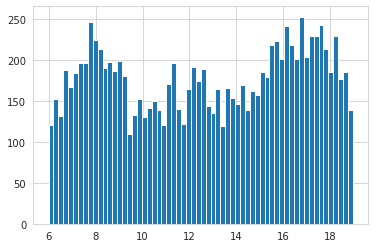

In [69]:
# Get the times that buses are in our corridors
z = []
dates = data['locationtime'].values
dates
for time in dates:
    x = int(datetime.fromtimestamp(time).strftime("%-M"))/60
    y = int(datetime.fromtimestamp(time).strftime("%H"))
    z.append(x+y)
plt.hist(z, bins=62)

In [ ]:
# Get the average number of traversals per corridor
# Want count of unique trip ids for each segment id
traversal_data = data.groupby(['seg_compkey']).nunique('tripid').reset_index()
for corridor in corridor_segments:
    corridor_data = traversal_data.loc[traversal_data['seg_compkey'].isin(list(corridor_segments[corridor]))]
    print(corridor_data['lat'].mean())

In [ ]:
# Get the top ten vehicles with most tracked locations
vehicle_counts = data.groupby('vehicleid').count().reset_index()[['vehicleid', 'lat']]
vehicle_list = vehicle_counts.sort_values('lat', ascending=False)
vehicle_list = vehicle_list.iloc[:10,:]
vehicle_list = vehicle_list['vehicleid'].values
corridor_data_10 = data[data['vehicleid'].isin(vehicle_list)]
print(f"Number of tracks for best 10 routes: {len(corridor_data_10)}")

# Get the data corresponding to ten random vehicles
vehicle_list = vehicle_counts.sample(10)
vehicle_list = vehicle_list.sort_values('lat', ascending=False)
vehicle_list = vehicle_list.iloc[0:1,:]
vehicle_list = vehicle_list['vehicleid'].values
corridor_data_rand = data[data['vehicleid'].isin(vehicle_list)]
print(f"Number of tracks for best random route: {len(corridor_data_rand)}")

### Generate Densities by Random Sampling

In [ ]:
# 1000 iterations for random 10 vehicle ids from past two weeks
best_route_name = []
best_route_count = []
for i in range(0, 1000):
    sample = vehicle_counts.sample(10)
    sample = sample.sort_values('lat', ascending=False)
    sample = sample.iloc[0:1,:]
    best_route_name.append(sample['vehicleid'].values[0])
    best_route_count.append(sample['lat'].values[0])

# The top 20 vehicles
top_route_name = []
top_route_count = []
sample = vehicle_counts.sort_values('lat', ascending=False)
sample = sample.iloc[:10,:]
top_route_name.append(sample['vehicleid'].values)
top_route_count.append(sample['lat'].values)
top_route_count = list(top_route_count[0])

# All vehicles
all_route_count = list(vehicle_counts['lat'].values)

In [ ]:
# Distribution of number of tracks across network
fig = plt.figure(figsize=(10,6))
sns.kdeplot(best_route_count, bw_adjust=1)
sns.kdeplot(top_route_count, bw_adjust=1)
sns.kdeplot(all_route_count, bw_adjust=1)
fig.legend(labels=['Top Sampled Count','Top Un-Sampled Count','All Counts'])

### Generate Spatial Heatmaps

In [ ]:
pd.unique(corridor_data_rand['route_short_name'])

In [ ]:
# Initialize the map
f_map = folium.Map(
    location=[47.606209, -122.332069],
    zoom_start=11,
    prefer_canvas=True)

# Create and add layer for all the sampled coordinate data
# lats = sampled['lat'].tolist()
# lons = sampled['lon'].tolist()
# points = zip(lats, lons)
# points = list(points)
# HeatMap(
#     data=points,
#     name='Points',
#     radius=8,
#     min_opacity=0.2
# ).add_to(f_map)

# Create and add layer for all the sampled coordinate data in our corridors
lats = corridor_data_rand['lat'].tolist()
lons = corridor_data_rand['lon'].tolist()
points = zip(lats, lons)
points = list(points)
HeatMap(
    data=points,
    name='Points',
    radius=8,
    min_opacity=0.2
).add_to(f_map)

folium.LayerControl().add_to(f_map)

# Save map and plot in notebook
f_map.save(f"./local_sampled_map.html")
f_map